In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import random
from flax.training import checkpoints

import sys
import os
sys.path.append('synthetic-am')
from dynamics import dynamics
from dynamics import utils as dutils
import datasets

from models import utils as mutils
from models import ddpm, anet
import train_utils as tutils
import eval_utils as eutils

/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
2023-09-29 02:24:33.118473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:/pkgs/cuda-11.3/lib64:/pkgs/nccl_2.9.9-1+cuda11.3_x86_64:/pkgs/nccl_2.8.3-1+cuda11.0_x86_64/lib:/pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib
2023-09-29 02:24:33.119031: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

In [3]:
from configs import cifar_ot_gen as config
config = config.get_config()
ckpt_id = 

In [65]:
workdir = f'synthetic-am/checkpoint/{ckpt_id}'
key = random.PRNGKey(0)
config.eval.use_ema = True
# init model
key, init_key = random.split(key)
model, _, initial_params = mutils.init_model(init_key, config.model_s)
optimizer = tutils.get_optimizer(config.optimizer_s)
opt_state = optimizer.init(initial_params)

# init dynamics
dynamics = dutils.get_dynamics(config.data.dynamics)
time_sampler, init_sampler_state = dutils.get_time_sampler(config)

state = mutils.State(step=0, opt_state=opt_state,
                     model_params=initial_params,
                     ema_rate=config.model_s.ema_rate,
                     params_ema=initial_params,
                     sampler_state=init_sampler_state,
                     key=key, wandbid=np.random.randint(int(1e7),int(1e8)))

checkpoint_dir = os.path.join(workdir, "checkpoints")
state = checkpoints.restore_checkpoint(checkpoint_dir, state, prefix='chkpt_s')

In [74]:
batch_iterator, scaler, inverse_scaler = datasets.get_batch_iterator(config)

batch_key, key = random.split(key)
batch = batch_iterator(batch_key)
batch = batch[0]

artifact_shape = (128, 
                  config.data.image_size, 
                  config.data.image_size, 
                  config.data.num_channels)
key, *artifact_keys = random.split(key, 10)
batch = batch[0,0][:artifact_shape[0]]

2023-09-29 02:44:55.185566: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
from functools import partial
import diffrax

def artifact_generator(key, state, x_0):
  x_0 = x_0[:x_0.shape[0]//2]
  s = mutils.get_model_fn(model, 
                          state.params_ema if config.eval.use_ema else state.model_params, 
                          train=False)
  if 'unet' == config.model_s.name:
    dsdx = s
  else:
    dsdx = jax.grad(lambda _t, _x: s(_t, _x).sum(), argnums=1)
  vector_field = lambda _t,_x,_args: dsdx(_t,_x)
  solve = partial(diffrax.diffeqsolve, 
                  terms=diffrax.ODETerm(vector_field), 
                  solver=diffrax.Dopri5(), 
                  t0=0.0, t1=1.0, dt0=1e-3, 
                  saveat=diffrax.SaveAt(ts=[1.0]),
                  stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-5), 
                  adjoint=diffrax.NoAdjoint())
  solution = solve(y0=x_0, args=state)
  one_step_artifacts = x_0 + dsdx(jnp.zeros((x_0.shape[0], 1, 1, 1)), x_0)
  artifacts = jnp.stack([solution.ys[-1][:,:,:,:artifact_shape[3]], one_step_artifacts], 0)
  return artifacts, solution.stats['num_steps']
artifact_generator = jax.jit(artifact_generator)

In [75]:
artifacts_0, nfe_0 = artifact_generator(artifact_keys[0], state, batch)
# artifacts_1, nfe_1 = artifact_generator(artifact_keys[1], state, batch)
print(nfe_0)

13


In [76]:
H, W, C = 32, 32, 3
artifacts = np.ones((3*(2*H + 5)-5, 20*W,C))
for i in range(3):
  for j in range(20):
    artifacts[i*(2*H+5):i*(2*H+5)+H, j*W:(j+1)*W, :] = inverse_scaler(artifacts_0[0,i*20+j])
    artifacts[i*(2*H+5)+H:i*(2*H+5)+2*H, j*W:(j+1)*W, :] = inverse_scaler(artifacts_0[1,i*20+j])

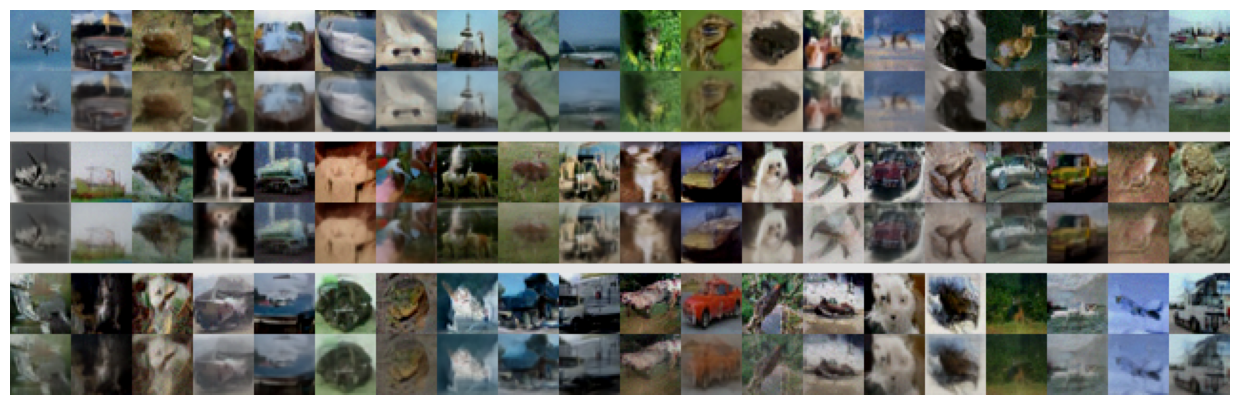

In [77]:
figsize(16,5)
plt.imshow(artifacts-0.1, cmap='gray')
plt.box(False)
plt.xticks([], [])
plt.yticks([], [])
# plt.savefig('synthetic-am/assets/cifar_ot_2.pdf', bbox_inches='tight')
plt.show()

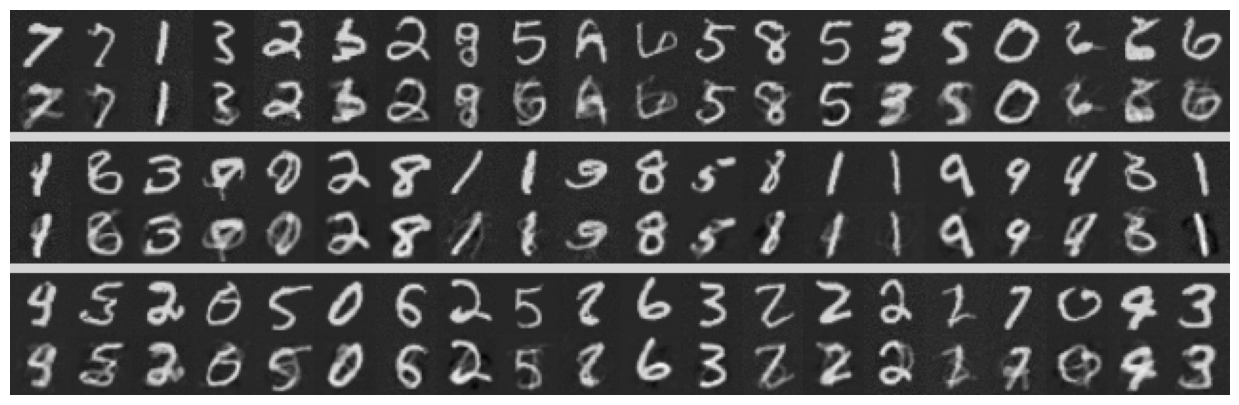

In [ ]:
figsize(16,5)
plt.imshow(artifacts, cmap='gray')
plt.box(False)
plt.xticks([], [])
plt.yticks([], [])
# plt.savefig('synthetic-am/assets/mnist_ot.pdf', bbox_inches='tight')
plt.show()